In [31]:
import torch
import torch.nn as nn
from torchvision import models

In [32]:
class encoderCNN(nn.Module):
    def __init__(self, embed_size, should_train=False):
        super(encoderCNN, self).__init__()
        self.should_train = should_train
        self.resnet = models.resnet18(pretrained=True)
        
        # Replace the fully connected layer with a new one that outputs embed_size
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
        # Freeze parameters if should_train is False
        for name, param in self.resnet.named_parameters():
            param.requires_grad = self.should_train
        
        # Always train the final fully connected layer
        for name, param in self.resnet.fc.named_parameters():
            param.requires_grad = True
    
    def forward(self, x):
        features = self.resnet(x)
        return self.dropout(self.relu(features))

In [89]:
class decoderRNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(decoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, caption):
        # Embed the captions
        embeddings = self.dropout(self.embedding(caption))
        # Concatenate features and embeddings
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        # Pass through LSTM
        hiddens, _ = self.lstm(embeddings)
        # Linear layer to get vocab scores
        outputs = self.linear(hiddens)
        return outputs

In [91]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, num_layers):
        super(CNN2RNN, self).__init__()
        self.encoderCNN = encoderCNN(embed_size)
        self.decoderRNN = decoderRNN(embed_size, vocab_size, hidden_size, num_layers)
    
    def forward(self, images, caption):
        x = self.encoderCNN(images)
        x = self.decoderRNN(x, caption)
        return x
    
    def captionImage(self, image, vocabulary, maxlength=50):
        result_caption = []
        
        with torch.no_grad():
            # Encode the image
            x = self.encoderCNN(image).unsqueeze(0)  # Shape: (1, batch_size, embed_size)
            states = None
            
            for _ in range(maxlength):
                # Pass through LSTM
                hiddens, states = self.decoderRNN.lstm(x, states)
                output = self.decoderRNN.linear(hiddens.squeeze(0))  # Shape: (batch_size, vocab_size)
                predicted = output.argmax(1)  # Shape: (batch_size)
                
                
                # Append the predicted word to the result
                result_caption.append(predicted.item())
                
                # Embed the predicted word for the next input
                x = self.decoderRNN.embedding(predicted).unsqueeze(0)  # Shape: (1, batch_size, embed_size)
              
                
                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break
        
        return [vocabulary.itos[i] for i in result_caption]

In [52]:
import os
import pandas
import spacy

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from torchvision.transforms import transforms
from collections import Counter

In [53]:
# Load the English language model
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold, max_vocab_size=10000):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
        self.max_vocab_size = max_vocab_size
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self, sentences):
        frequency = Counter()
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                frequency[word] += 1
        
        # Keep only the most frequent words up to max_vocab_size
        most_common = frequency.most_common(self.max_vocab_size - 4)
        
        idx = 4
        for word, freq in most_common:
            if freq >= self.freq_threshold:
                self.itos[idx] = word
                self.stoi[word] = idx
                idx += 1
    
    def numericalize(self, sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text]

In [54]:
annotation = pandas.read_csv("/data4/home/prabhasreddy/projects/flickr8k/captions.txt")
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [55]:
annotation['caption'].tolist()[:2]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .']

In [56]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir="/data4/home/prabhasreddy/projects/flickr8k/images/", caption_path="/data4/home/prabhasreddy/projects/flickr8k/captions.txt", freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold,max_vocab_size=10000)
        
        print(len(self.captions.tolist()))
        self.vocab.build_vocabulary(self.captions.tolist())
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [71]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)
        
        return img, targets

In [72]:
# transform = transforms.Compose(
#         [transforms.Resize((224, 224)), transforms.ToTensor(),]
#     )

transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ]
    )

In [73]:
def get_loader(root_dir="/data4/home/prabhasreddy/projects/flickr8k/images/", caption_path="/data4/home/prabhasreddy/projects/flickr8k/captions.txt", transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=64, num_workers=8, shuffle=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [74]:
 loader, dataset = get_loader()

10000


Lets load a random example.

In [75]:
import random
import math

x, y = dataset[math.floor(random.random() * len(dataset))]
x.shape, y.shape

(torch.Size([3, 224, 224]), torch.Size([13]))

tensor([  1,   4,  16,   7,  26,   9, 647,  20,   4,  26,   3,   5,   2])
<SOS> a boy in red is pointing to a red <UNK> . <EOS> 

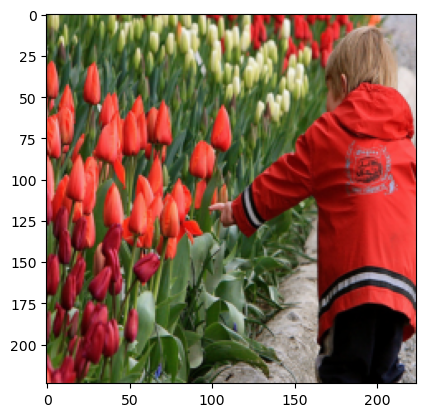

In [76]:
import matplotlib.pyplot as plt

plt.imshow(x.permute(1,2,0))
print(y)

# print(dataset.vocab.itos[1])

for i in y:
    print(dataset.vocab.itos[int(i)],end=" ")

In [77]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
    print("saving checkpoint!")
    torch.save(state, filename)

In [78]:
def load_checkpoint(checkpoint, model, optimizer):
    print("loading checkpoint!")
    model.load_state_dict(checkpoint["state_dict"])
    model.load_state_optimizer(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

## Training the model

In [79]:
from tqdm import tqdm
# from torchvision.utils.tensorboard import SummaryWriter

In [80]:
torch.backends.cudnn.benchmark = True
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
load_model = False
save_model=False
train_CNN = False

In [81]:
# model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

### Hyperparameters

In [82]:
import torch.optim as optim 

step = 0
embed_size = 512
hidden_size = 512
num_layers = 2
num_epochs = 20
learning_rate = 0.001
vocab_size = len(dataset.vocab)


In [92]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size,vocab_size=vocab_size, num_layers=num_layers).to(device=device)

In [93]:
model.decoderRNN

decoderRNN(
  (embedding): Embedding(1358, 512)
  (lstm): LSTM(512, 512, num_layers=2)
  (linear): Linear(in_features=512, out_features=1358, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [94]:
loss_criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [95]:
# Only finetune the CNN
for name, param in model.encoderCNN.resnet.named_parameters():
    if "fc.weight" in name or "fc.bias" in name:
        param.requires_grad = True
    else:
        param.requires_grad = train_CNN

In [96]:
if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [97]:
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0  # Initialize epoch loss

    for idx, (imgs, captions) in enumerate(loader):
        # Move data to the appropriate device
        imgs = imgs.to(device)
        captions = captions.to(device)
        
        # Forward pass
        outputs = model(imgs, captions[:, :-1])
        
        # Compute loss
        loss = loss_criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
        step += 1
        
        # Print loss every 100 steps
        if step % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step}], Loss: {loss.item():.4f}")
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(loader)
    print(f"Loss for epoch {epoch+1}: {avg_epoch_loss:.4f}")

Loss for epoch 0: 3.1264169216156006
Loss for epoch 1: 2.831383228302002
Loss for epoch 2: 2.869478940963745
Loss for epoch 3: 2.585707187652588
Loss for epoch 4: 2.620757818222046
Loss for epoch 5: 2.599327802658081
Loss for epoch 6: 2.590116262435913
Loss for epoch 7: 2.3571205139160156
Loss for epoch 8: 2.2606990337371826
Loss for epoch 9: 2.4510951042175293
Loss for epoch 10: 2.285727024078369
Loss for epoch 11: 1.9573562145233154
Loss for epoch 12: 2.0081229209899902
Loss for epoch 13: 1.6823291778564453
Loss for epoch 14: 1.8776404857635498
Loss for epoch 15: 1.9659746885299683
Loss for epoch 16: 1.8067572116851807
Loss for epoch 17: 1.7206478118896484
Loss for epoch 18: 1.7444673776626587
Loss for epoch 19: 1.654213786125183


['<SOS>', 'a', 'boy', 'in', 'a', 'red', 'jacket', 'is', 'playing', 'with', 'a', 'red', 'ball', '.', '<EOS>']


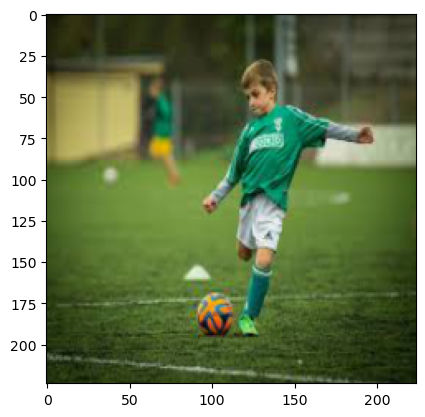

In [100]:
image_path = "/data4/home/prabhasreddy/projects/test.jpeg"
img = Image.open(image_path)
img = transform(img)
plt.imshow(img.permute(1,2,0))

image_input = img.to(device=device) # check here
image_input = image_input.unsqueeze(0)
#print(image_input.shape)
model.eval()
print(model.captionImage(image=image_input, vocabulary=dataset.vocab))